## Accessing Sentinel-2 L2A data with the Planetary Computer STAC API

The [Sentinel-2](https://sentinel.esa.int/web/sentinel/missions/sentinel-2) program provides global imagery in thirteen spectral bands at 10m-60m resolution and a revisit time of approximately five days.  This dataset represents the global Sentinel-2 archive, from 2016 to the present, processed to L2A (bottom-of-atmosphere) using [Sen2Cor](https://step.esa.int/main/snap-supported-plugins/sen2cor/) and converted to [cloud-optimized GeoTIFF](https://www.cogeo.org/) format.  The digital elevation model used for terrain correction was [Planet DEM 30](https://planetobserver.com/global-elevation-data/).

This notebook demonstrates the use of the Planetary Computer STAC API to query for Sentinel-2 tiles.

This notebook works with or without an API key, but you will be given more permissive access to the data with an API key.
The [Planetary Computer Hub](https://planetarycomputer.microsoft.com/compute) is pre-configured to use your API key.

### Environment setup

This notebook works with or without an API key, but you will be given more permissive access to the data with an API key. The Planetary Computer Hub is pre-configured to use your API key.

In [1]:
from pystac.extensions.eo import EOExtension as eo
import pystac_client
import planetary_computer

# Set the environment variable PC_SDK_SUBSCRIPTION_KEY, or set it here.
# The Hub sets PC_SDK_SUBSCRIPTION_KEY automatically.
# pc.settings.set_subscription_key(<YOUR API Key>)

### Data access

The datasets hosted by the Planetary Computer are available from [Azure Blob Storage](https://docs.microsoft.com/en-us/azure/storage/blobs/). We'll use [pystac-client](https://pystac-client.readthedocs.io/) to search the Planetary Computer's [STAC API](https://planetarycomputer.microsoft.com/api/stac/v1/docs) for the subset of the data that we care about, and then we'll load the data directly from Azure Blob Storage. We'll specify a `modifier` so that we can access the data stored in the Planetary Computer's private Blob Storage Containers. See [Reading from the STAC API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) and [Using tokens for data access](https://planetarycomputer.microsoft.com/docs/concepts/sas/) for more.

In [2]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

### Choose a region and time of interest

This area is near Jonah Bay, Alaska.

In [3]:
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [-148.56536865234375, 60.80072385643073],
            [-147.44338989257812, 60.80072385643073],
            [-147.44338989257812, 61.18363894915102],
            [-148.56536865234375, 61.18363894915102],
            [-148.56536865234375, 60.80072385643073],
        ]
    ],
}

Define the time range to filter images with. Here we use the summer of 2019.

In [4]:
time_of_interest = "2019-06-01/2019-08-01"

In [5]:
search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=area_of_interest,
    datetime=time_of_interest,
    query={"eo:cloud_cover": {"lt": 10}},
)

# Check how many items were returned
items = search.item_collection()
print(f"Returned {len(items)} Items")

Returned 5 Items


We can now work directly with the [PySTAC](https://github.com/stac-utils/pystac) Items returned by the API. Here we find the least cloudy of the bunch.

In [6]:
least_cloudy_item = min(items, key=lambda item: eo.ext(item).cloud_cover)

print(
    f"Choosing {least_cloudy_item.id} from {least_cloudy_item.datetime.date()}"
    f" with {eo.ext(least_cloudy_item).cloud_cover}% cloud cover"
)

Choosing S2B_MSIL2A_20190629T212529_R043_T06VVN_20201006T080531 from 2019-06-29 with 0.314306% cloud cover


Get the URL to the [Cloud Optimized GeoTIFF](https://www.cogeo.org/) image corresponding to the true color composite image.

In [7]:
asset_href = least_cloudy_item.assets["visual"].href

We can now use the HREF to read our data in any tools that can retrieve data from URLs via HTTP GET operations.

For example, here we use rasterio to render the image data over our area of interest:

### Render our AOI from this image

In [8]:
import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp

import numpy as np
from PIL import Image

with rasterio.open(asset_href) as ds:
    aoi_bounds = features.bounds(area_of_interest)
    warped_aoi_bounds = warp.transform_bounds("epsg:4326", ds.crs, *aoi_bounds)
    aoi_window = windows.from_bounds(transform=ds.transform, *warped_aoi_bounds)
    band_data = ds.read(window=aoi_window)

rasterio gives us data band-interleave format; transpose to pixel-interleave, and downscale the image data for plotting.

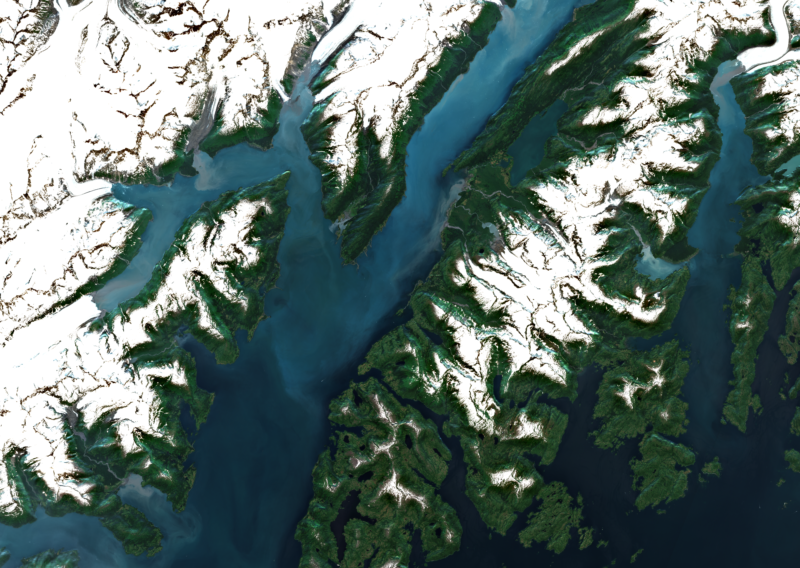

In [9]:
img = Image.fromarray(np.transpose(band_data, axes=[1, 2, 0]))
w = img.size[0]
h = img.size[1]
aspect = w / h
target_w = 800
target_h = (int)(target_w / aspect)
img.resize((target_w, target_h), Image.Resampling.BILINEAR)

In [2]:
import os
import requests
import geopandas as gpd
from shapely.geometry import mapping
import rasterio
import rasterio.mask
from rasterio.merge import merge
import matplotlib.pyplot as plt

from pystac_client import Client
import planetary_computer


In [3]:
# -------------------------------------------------------------------
# 1. READ TOGO BOUNDARY
# -------------------------------------------------------------------
adm_url = "https://github.com/wmgeolab/geoBoundaries/raw/9469f09/releaseData/gbOpen"
tgo_adm0_fp = f"{adm_url}/TGO/ADM0/geoBoundaries-TGO-ADM0.geojson"
tgo_gdf = gpd.read_file(tgo_adm0_fp)
tgo_aoi = mapping(tgo_gdf.geometry[0])  # geometry dict for STAC


In [4]:
# -------------------------------------------------------------------
# 2. SEARCH SENTINEL-2 COLLECTION ON PLANETARY COMPUTER
# -------------------------------------------------------------------
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=tgo_aoi,
    datetime="2023-12-01/2024-02-29",  # Dec 2023 - Feb 2024
    query={"eo:cloud_cover": {"lt": 15}},  # <15% cloud cover
)

items = list(search.get_items())
print(f"Total items found: {len(items)}")


/Users/cullenmolitor/miniconda3/envs/mosaiks/lib/python3.12/site-packages/pystac_client/item_search.py:888: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


Total items found: 320


In [10]:
# -------------------------------------------------------------------
# 3. DOWNLOAD & CLIP EACH BAND TO TOGO BOUNDARY
# -------------------------------------------------------------------
# Create an output directory for the individual clipped scenes
os.makedirs("sentinel_togo/clipped_scenes", exist_ok=True)

clipped_files = []

for idx, item in enumerate(items):
    # Sign the entire item to get valid (time-limited) asset URLs
    signed_item = planetary_computer.sign(item)

    # Choose an asset to download. Here we use band B04 (red).
    # If you want something else (e.g., "visual" or "B08"), change here.
    if "B04" not in signed_item.assets:
        # Some scenes (rare) may lack certain bands; skip if missing
        continue

    asset_href = signed_item.assets["B04"].href

    # Download the TIFF
    local_tiff_path = f"sentinel_togo/B04_{idx}.tif"
    if not os.path.exists(local_tiff_path):
        r = requests.get(asset_href, stream=True)
        r.raise_for_status()
        with open(local_tiff_path, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)

    # Clip to Togo’s boundary
    with rasterio.open(local_tiff_path) as src:
        # Reproject Togo boundary if needed
        if tgo_gdf.crs != src.crs:
            tgo_gdf_aligned = tgo_gdf.to_crs(src.crs)
        else:
            tgo_gdf_aligned = tgo_gdf
            
        # Mask (clip) using the Togo boundary in the same CRS as the raster
        out_image, out_transform = rasterio.mask.mask(
            src,
            tgo_gdf_aligned.geometry,
            crop=True,
            all_touched=True,
            nodata=0  # or use src.nodata if set
        )
        out_meta = src.meta.copy()
        out_meta.update({
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform,
            "nodata": 0,
        })

    clipped_path = f"sentinel_togo/clipped_scenes/B04_{idx}_clip.tif"
    with rasterio.open(clipped_path, "w", **out_meta) as dst:
        dst.write(out_image)

    clipped_files.append(clipped_path)


RasterioIOError: Read failed. See previous exception for details.

In [6]:
# -------------------------------------------------------------------
# 4. MOSAIC THE CLIPPED SCENES
# -------------------------------------------------------------------
src_files_to_mosaic = [rasterio.open(fp) for fp in clipped_files]
mosaic_arr, mosaic_transform = merge(src_files_to_mosaic)

# Copy metadata from the first scene, then update for mosaic
mosaic_meta = src_files_to_mosaic[0].meta.copy()
mosaic_meta.update(
    {
        "height": mosaic_arr.shape[1],
        "width": mosaic_arr.shape[2],
        "transform": mosaic_transform,
        "nodata": 0,
    }
)

# Save mosaic
mosaic_path = "sentinel_togo/B04_mosaic_togo.tif"
with rasterio.open(mosaic_path, "w", **mosaic_meta) as dst:
    dst.write(mosaic_arr)

# Close open files
for src in src_files_to_mosaic:
    src.close()


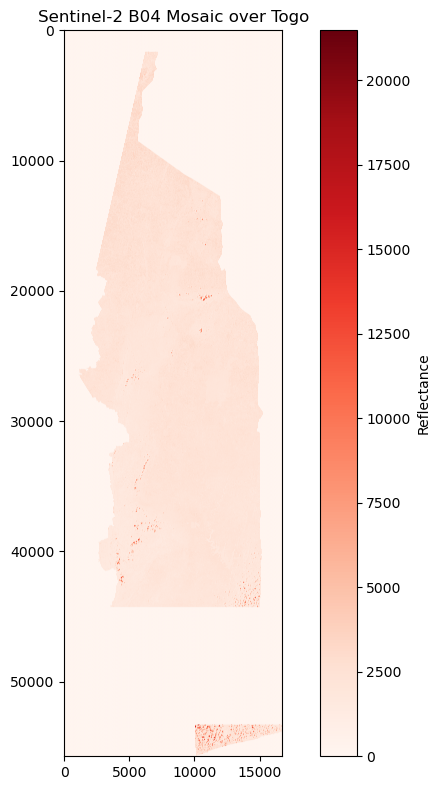

In [7]:

# -------------------------------------------------------------------
# 5. VISUALIZE THE MOSAIC
# -------------------------------------------------------------------
with rasterio.open(mosaic_path) as src:
    fig, ax = plt.subplots(figsize=(8, 8))
    # Read the single band (1) for B04
    band = src.read(1)
    show_img = ax.imshow(band, cmap="Reds")  # or any other colormap you prefer
    ax.set_title("Sentinel-2 B04 Mosaic over Togo")
    plt.colorbar(show_img, ax=ax, label="Reflectance")
    plt.tight_layout()
    plt.show()


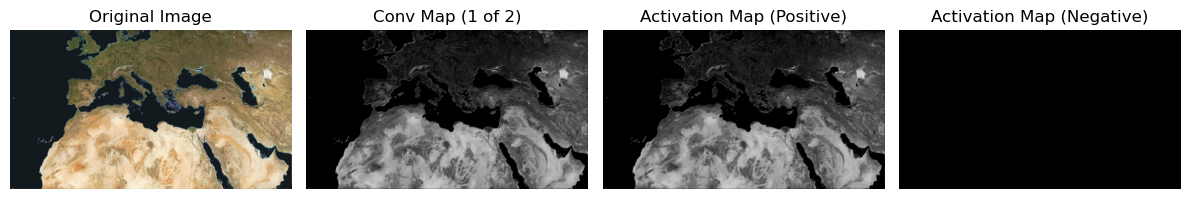

In [91]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import requests
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import torchvision.transforms as transforms


class RCF(nn.Module):
    """
    A model for extracting Random Convolution Features (RCF) from input imagery
    with optional outputs for the raw convolution layer or the activation map.
    """

    def __init__(
        self,
        num_features=4,         # Using 4 features for simplicity
        kernel_size=3,
        num_input_channels=3,
        return_conv=False,      # Set True to return the raw convolution outputs
        return_activation=False, # Set True to return the activation map
        seed=42                 # Seed for reproducibility
    ):
        super(RCF, self).__init__()
        # Set the seed for reproducibility
        torch.manual_seed(seed)

        # We create `num_features / 2` filters so require `num_features` to be divisible by 2
        assert num_features % 2 == 0

        self.return_conv = return_conv
        self.return_activation = return_activation

        self.conv1 = nn.Conv2d(
            num_input_channels,
            num_features // 2,
            kernel_size=kernel_size,
            stride=1,
            padding=kernel_size // 2,  # Ensure input shape is preserved
            dilation=1,
            bias=True,
        )

        # Initialize weights and bias with fixed random values
        nn.init.normal_(self.conv1.weight, mean=0.0, std=1.0)
        nn.init.constant_(self.conv1.bias, -1.0)

    def forward(self, x):
        # Convolution
        conv_output = self.conv1(x)
        # Activation
        x1a = F.relu(conv_output, inplace=True)
        x1b = F.relu(-conv_output, inplace=True)

        # Global average pooling
        x1a_pooled = F.adaptive_avg_pool2d(x1a, (1, 1)).squeeze()
        x1b_pooled = F.adaptive_avg_pool2d(x1b, (1, 1)).squeeze()

        # Concatenate features
        if len(x1a_pooled.shape) == 1:  # Case where we passed a single input
            features = torch.cat((x1a_pooled, x1b_pooled), dim=0)
        else:  # Batch of > 1 inputs
            features = torch.cat((x1a_pooled, x1b_pooled), dim=1)

        # Return requested values
        outs = [features]
        if self.return_conv:
            outs.append(conv_output)
        if self.return_activation:
            outs.append((x1a, x1b))
        return outs if len(outs) > 1 else outs[0]


# Example usage
# Load the image directly from the URL without resizing
url = (
    "https://cdn.sanity.io/images/hvd5n54p/production/"
    "a332510258992b73c57a72177a391a331c91c951-945x531.jpg?"
    "w=1200&auto=format"
)
url = ("https://cdn.sanity.io/images/hvd5n54p/production/395398de2fd43f81885f2be3d8187dcab1733c89-1224x693.jpg?w=1200&auto=format")

response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert("RGB")

# Convert the image to a tensor without resizing
transform = transforms.ToTensor()  # No resizing, just conversion to tensor
img_tensor = transform(img).unsqueeze(0)  # Add batch dimension

# Initialize the model with a fixed seed
model = RCF(num_features=4, return_conv=True, return_activation=True, seed=42)

# Pass the image through the model
outputs = model(img_tensor)

# Unpack the outputs
features, conv_map, (act_pos, act_neg) = outputs

# Plot results
fig, axs = plt.subplots(1, 4, figsize=(12, 4))

# Original image
axs[0].imshow(img)
axs[0].set_title("Original Image")
axs[0].axis("off")

# For visualization, pick one feature map from the convolution output
conv_map_vis = conv_map[0, 0].detach().cpu().numpy()
axs[1].imshow(conv_map_vis, cmap="gray")
axs[1].set_title("Conv Map (1 of 2)")
axs[1].axis("off")

# Similarly, pick one feature map from activation
act_pos_vis = act_pos[0, 0].detach().cpu().numpy()
axs[2].imshow(act_pos_vis, cmap="gray")
axs[2].set_title("Activation Map (Positive)")
axs[2].axis("off")

act_neg_vis = act_neg[0, 0].detach().cpu().numpy()
axs[3].imshow(act_neg_vis, cmap="gray")
axs[3].set_title("Activation Map (Negative)")
axs[3].axis("off")

plt.tight_layout()
plt.show()


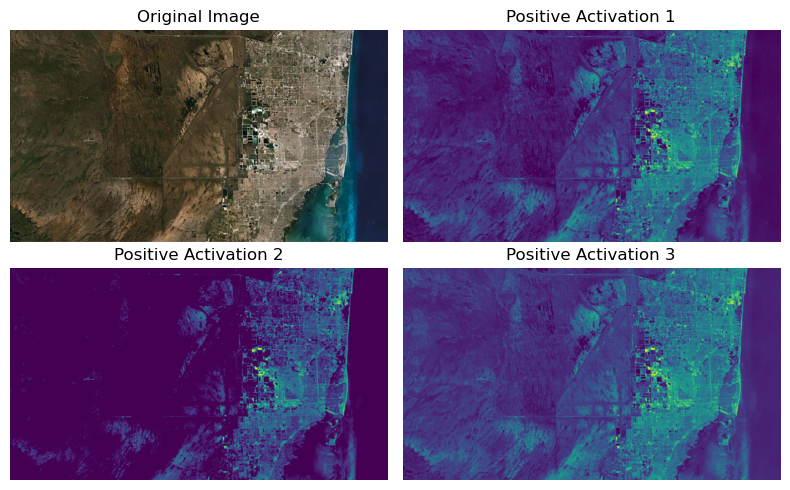

In [90]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import requests
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import torchvision.transforms as transforms
import numpy as np


class RCFWithPatchSampling(nn.Module):
    """
    A model for extracting Random Convolution Features (RCF) with patch sampling
    from the input image for empirical convolution kernels.
    """

    def __init__(
        self,
        num_features=6,  # Number of features to compute (must be divisible by 2)
        kernel_size=3,
        num_input_channels=3,
        patch_sampling=True,  # Enable empirical patch sampling
        seed=42,  # Seed for reproducibility
    ):
        super(RCFWithPatchSampling, self).__init__()
        # Set the seed for reproducibility
        torch.manual_seed(seed)

        assert num_features % 2 == 0, "num_features must be divisible by 2"
        self.num_features = num_features
        self.kernel_size = kernel_size
        self.patch_sampling = patch_sampling
        self.seed = seed

        if patch_sampling:
            self.register_buffer(
                "weights",
                torch.zeros(
                    num_features // 2,
                    num_input_channels,
                    kernel_size,
                    kernel_size,
                    requires_grad=False,
                ),
            )
            self.register_buffer(
                "biases", torch.zeros(num_features // 2, requires_grad=False) - 1.0
            )
        else:
            self.conv1 = nn.Conv2d(
                num_input_channels,
                num_features // 2,
                kernel_size=kernel_size,
                stride=1,
                padding=kernel_size // 2,  # Ensure input shape is preserved
                bias=True,
            )
            nn.init.normal_(self.conv1.weight, mean=0.0, std=1.0)
            nn.init.constant_(self.conv1.bias, -1.0)

    def extract_patches(self, img_tensor):
        """Extracts patches for empirical sampling."""
        _, c, h, w = img_tensor.shape
        np.random.seed(self.seed)
        for i in range(self.num_features // 2):
            y = np.random.randint(0, h - self.kernel_size)
            x = np.random.randint(0, w - self.kernel_size)
            patch = img_tensor[0, :, y : y + self.kernel_size, x : x + self.kernel_size]
            self.weights[i] = patch

    def forward(self, x):
        if self.patch_sampling:
            self.extract_patches(x)
            conv_output = F.conv2d(
                x, self.weights, bias=self.biases, stride=1, padding=0
            )
        else:
            conv_output = self.conv1(x)

        # Activation
        x1a = F.relu(conv_output, inplace=True)

        # Global average pooling
        x1a_pooled = F.adaptive_avg_pool2d(x1a, (1, 1)).squeeze()

        return x1a, conv_output


seed = 42
# Example usage
url = (
    "https://cdn.sanity.io/images/hvd5n54p/production/"
    "a332510258992b73c57a72177a391a331c91c951-945x531.jpg?"
    "w=1200&auto=format"
)
response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert("RGB")

# Convert the image to a tensor
transform = transforms.ToTensor()
img_tensor = transform(img).unsqueeze(0)

# Initialize the model
model = RCFWithPatchSampling(num_features=6, patch_sampling=True, seed=seed)

# Pass the image through the model
act_pos, conv_map = model(img_tensor)

# Plot results in a 2x2 layout
fig, axs = plt.subplots(2, 2, figsize=(8, 5))

# Original image
axs[0, 0].imshow(img)
axs[0, 0].set_title("Original Image")
axs[0, 0].axis("off")

# Positive activation maps
for i in range(3):
    act_pos_vis = act_pos[0, i].detach().cpu().numpy()
    axs[(i + 1) // 2, (i + 1) % 2].imshow(act_pos_vis, cmap="viridis")
    axs[(i + 1) // 2, (i + 1) % 2].set_title(f"Positive Activation {i + 1}")
    axs[(i + 1) // 2, (i + 1) % 2].axis("off")

plt.tight_layout()
plt.show()
